### 統計學習與深度學習 HW4
### 會計四 B06702064 林聖硯

In [3]:
#load packages
%matplotlib inline
import pickle
from sklearn import preprocessing

#Load data
with open('data/msd_full.pickle', 'rb') as fh1:
    msd_data = pickle.load(fh1)

doscaling = 1
if (doscaling == 1):
    xscaler = preprocessing.StandardScaler().fit(msd_data['X_train'])
    #standardize feature values
    X_train = xscaler.transform(msd_data['X_train'])
    X_test = xscaler.transform(msd_data['X_test'])
else:
    X_train = msd_data['X_train']
    X_test = msd_data['X_test']

Y_train = msd_data['Y_train']
Y_test = msd_data['Y_test'].astype('float32')
X_test = X_test.astype('float32')

y_mean = Y_train.mean()
Y_train_keep = Y_train.copy()
Y_test_keep = Y_test.copy()
Y_train = Y_train - y_mean
Y_test = Y_test - y_mean


#validation is the last 10% of training, subtraining is the first 90% of training
nvalid = int(X_train.shape[0] * 0.1)
nsubtrain = X_train.shape[0] - nvalid

X_subtrain = X_train[0:nsubtrain, :].astype('float32')
X_valid = X_train[nsubtrain:, :].astype('float32')
Y_subtrain = Y_train[0:nsubtrain].astype('float32')
Y_valid = Y_train[nsubtrain:].astype('float32')

Y_subtrain_keep = Y_train_keep[0:nsubtrain].astype('float32')
Y_valid_keep = Y_train_keep[nsubtrain:].astype('float32')

print("X_train shape = ", X_train.shape)
print("X_subtrain shape = ", X_subtrain.shape)
print("X_valid shape = ", X_valid.shape)
print("X_test shape = ", X_test.shape)
print("Y_train shape = ", Y_train.shape)
print("Y_subtrain shape = ", Y_subtrain.shape)
print("Y_valid shape = ", Y_valid.shape)
print("Y_test shape = ", Y_test.shape)

X_train shape =  (463715, 90)
X_subtrain shape =  (417344, 90)
X_valid shape =  (46371, 90)
X_test shape =  (51630, 90)
Y_train shape =  (463715,)
Y_subtrain shape =  (417344,)
Y_valid shape =  (46371,)
Y_test shape =  (51630,)


### Q1

In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [6]:
reg = LinearRegression().fit(X_train, Y_train)
y_pred = reg.predict(X_test)

In [10]:
print('RMSE = {}'.format(mean_squared_error(Y_test, y_pred, squared=False)))
print('First five weights= {}'.format(reg.coef_[:5]))

RMSE = 9.510160684544399
First five weights= [ 5.30975265 -2.88088114 -1.53234348  0.05737583 -0.33952889]


### Q2

In [ ]:
import numpy as np
import torch
from torch.utils import data
import matplotlib.pyplot as plt

In [ ]:
class Dataset(data.Dataset):
  #Characterizes a dataset for PyTorch
    def __init__(self, Xnp, Ynp):
        #Initialization, passing Xnp and Ynp
        self.labels = Ynp
        self.nobs = Xnp.shape[0]        
        self.Xnp = Xnp
        self.Ynp = Ynp
    def __len__(self):
        #Denotes the total numㄖber of samples
        return self.nobs
    def __getitem__(self, index):
        #Generates one sample of data      
        X = self.Xnp[index]
        y = self.Ynp[index]
        return X, y
     
subtrainset = Dataset(X_subtrain, Y_subtrain)
validset = Dataset(X_valid, Y_valid)
trainset = Dataset(X_train, Y_train)   
testset = Dataset(X_test, Y_test)

In [ ]:
subtrainloader = data.DataLoader(subtrainset, batch_size=1000)
validloader = data.DataLoader(validset, batch_size=1000)
trainloader = data.DataLoader(trainset, batch_size=1000)
testloader = data.DataLoader(testset, batch_size=1000)

In [ ]:
class myMLP():
    def __init__(self):
    self.batch_num = None
    self.subtrainRMSE = list()
    self.validRMSE = list()
    self.mse = torch.nn.MSELoss(reduction = 'mean')
    self.sse = torch.nn.MSELoss(reduction = 'sum')
    self.net = None

    def Net(self, input_shape, device, H = 45, dropout = False):
        D_in = input_shape
        D_out = 1
        if dropout == False:
            net = torch.nn.Sequential(
              torch.nn.Linear(D_in, H),  
              torch.nn.ReLU(),
              torch.nn.Linear(H, H),
              torch.nn.ReLU(),
              torch.nn.Linear(H, H),
              torch.nn.ReLU(),
              torch.nn.Linear(H, H),
              torch.nn.ReLU(),
              torch.nn.Linear(H, D_out)
          )

        else:
            net = torch.nn.Sequential(
              torch.nn.Linear(D_in, H),  
              torch.nn.ReLU(),
              torch.nn.Dropout(p = 0.5),
              torch.nn.Linear(H, H),
              torch.nn.ReLU(),
              torch.nn.Dropout(p = 0.5),
              torch.nn.Linear(H, H),
              torch.nn.ReLU(),
              torch.nn.Dropout(p = 0.5),
              torch.nn.Linear(H, H),
              torch.nn.ReLU(),
              torch.nn.Dropout(p = 0.5),
              torch.nn.Linear(H, D_out)
          )
        # convert everything to float precision. 
        net = net.float()
        # move the model to device (i.e., cpu or gpu)
        net = net.to(device)
        return net

  # Train
    def train(self, device, model, nepoch, log_interval, optimizer, train_loader, valid_loader, verbose = True):

        # Early stopping
        min_valid_loss = 10000000
        best_step_count = 0
        patience = 5000

        sum_loss_MSE = 0
        step_count = 0
        for epoch_idx in range(1, nepoch+1):
          #1 epoch = 400 batch (1 batch = 1000 data points)    
          for batch_idx, (inputs, targets) in enumerate(train_loader):
            model.train()
            #reshape target to two-dimensional array
            targets = targets.reshape((-1, 1))
            step_count += 1        
            model.train()
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            #loss for update        
            loss_SSE = self.sse(outputs, targets)
            #loss for show
            loss_MSE = self.mse(outputs, targets)
            loss_SSE.backward()
            optimizer.step()
            sum_loss_MSE += loss_MSE
            if step_count % log_interval == 0:
              #1000 = batch_size, 100 = number of batch         
                RMSE_train = (sum_loss_MSE / log_interval) ** (1/2)
                RMSE_valid = self.validation(model, device, log_interval, valid_loader)
                self.subtrainRMSE.append(RMSE_train)
                self.validRMSE.append(RMSE_valid)
                if verbose == True:
                    print("Epoch %d Step %d training loss = %.3f validation loss = %3f (minibatch size = %d)" % (epoch_idx, step_count, RMSE_train, RMSE_valid, len(targets))) 

                if RMSE_valid < min_valid_loss:
                    best_step_count = step_count
                    min_valid_loss = RMSE_valid
                    best_model = model
                sum_loss_MSE = 0 

            if step_count >= best_step_count + patience and RMSE_valid > min_valid_loss:
                if verbose == True:
                    print('Early stopping!')
                    print('='*50 + 'validation result' + '='*50)
                    print('the best step is {} with minimum validation error = {}'.format(best_step_count, min_valid_loss))
                self.batch_num = step_count
                return best_model
        if verbose == True:
            print('='*50 + 'result' + '='*50)
            print('the best step is {} with minimum validation error = {}'.format(best_step_count, min_valid_loss))
        self.batch_num = step_count
        return best_model


    def validation(self, model, device, log_interval, valid_loader):
    #切到evaluate的模式，不會進行gradient descent
        model.eval()
        total_loss = 0
        with torch.no_grad():
      #1 epoch = 40 batch
            for batch_idx, (inputs, targets) in enumerate(valid_loader):            
                inputs, targets = inputs.to(device), targets.to(device)
                targets = targets.reshape((-1, 1))
                outputs = model(inputs)        
                valid_loss = self.mse(outputs, targets)
                total_loss += valid_loss
        RMSE = (total_loss / batch_idx) ** (1/2)
        return RMSE

    def test(self, device, H, net, test_loader):
        net.eval()
        sum_test_MSE = 0
        with torch.no_grad():
            for batch_idx, (inputs, targets) in enumerate(test_loader):            
                inputs, targets = inputs.to(device), targets.to(device)
                targets = targets.reshape((-1, 1))
                outputs = net(inputs)        
                test_loss = self.mse(outputs, targets).item()
                sum_test_MSE += test_loss 
        test_RMSE = (sum_test_MSE / batch_idx) ** (1/2)
        return test_RMSE
  
    def plot(self):
        #print subtraining result
        fig = plt.figure()
        ax = plt.axes()
        x = np.linspace(100, self.batch_num, self.batch_num // 100)
        ax.plot(x, self.subtrainRMSE, label = 'subtrain RMSE')
        ax.plot(x, self.validRMSE, label = 'validation RMSE')
        ax.legend()
        #plt.title('H = {}')
        plt.show()

In [ ]:
# Settings
device = 'cuda' if torch.cuda.is_available() else 'cpu'
nepoch = 100
log_interval = 100
H = 45
lr = 0.00001
input_shape = subtrainset.Xnp.shape[1]

Q2_model = myMLP()
net = Q2_model.Net(input_shape, device, H)
optimizer = torch.optim.SGD(net.parameters(), lr = lr)
model = Q2_model.train(device, net, nepoch, log_interval, optimizer, subtrainloader, validloader, verbose = True)

Epoch 1 Step 100 training loss = 10.840 validation loss = 9.860864 (minibatch size = 1000)
Epoch 1 Step 200 training loss = 9.238 validation loss = 9.094234 (minibatch size = 1000)
Epoch 1 Step 300 training loss = 9.066 validation loss = 8.953245 (minibatch size = 1000)
Epoch 1 Step 400 training loss = 8.899 validation loss = 9.035228 (minibatch size = 1000)
Epoch 2 Step 500 training loss = 8.918 validation loss = 8.878045 (minibatch size = 1000)
Epoch 2 Step 600 training loss = 8.820 validation loss = 8.804682 (minibatch size = 1000)
Epoch 2 Step 700 training loss = 8.835 validation loss = 8.834981 (minibatch size = 1000)
Epoch 2 Step 800 training loss = 8.806 validation loss = 8.772099 (minibatch size = 1000)
Epoch 3 Step 900 training loss = 8.742 validation loss = 8.761466 (minibatch size = 1000)
Epoch 3 Step 1000 training loss = 8.767 validation loss = 8.798289 (minibatch size = 1000)
Epoch 3 Step 1100 training loss = 8.713 validation loss = 8.754601 (minibatch size = 1000)
Epoch 3

when H = 45, test_RMSE = 8.99610570623732


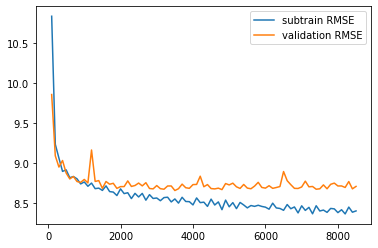

In [ ]:
test_RMSE = Q2_model.test(device, H, model, testloader)
print('when H = {}, test_RMSE = {}'.format(H, test_RMSE))
Q2_model.plot()

從圖形中可以看出，training RMSE持續下降但validation RMSE則到一個階段就停止，顯示出模型可能有overfitting的問題

### Q3

In [ ]:
# Settings
device = 'cuda' if torch.cuda.is_available() else 'cpu'
nepoch = 100
log_interval = 100
H_list = [45, 90, 180]
lr = 0.00001
input_shape = subtrainset.Xnp.shape[1]

for H in H_list: 
    Q3_model = myMLP()
    net = Q3_model.Net(input_shape, device, H)
    optimizer = torch.optim.SGD(net.parameters(), lr = lr)
    model = Q3_model.train(device, net, nepoch, log_interval, optimizer, subtrainloader, validloader, verbose = False)
    test_RMSE = Q3_model.test(device, H, model, testloader)
    print('when H = {}, test_RMSE = {}'.format(H, test_RMSE))

when H = 45, test_RMSE = 8.998106697083783
when H = 90, test_RMSE = 9.142651040361425
when H = 180, test_RMSE = 9.551088753182057


從結果可以看出，當H(hidden nodes)越大時，模型overfit的會越嚴重
雖然沒有把圖顯示在這裡(怕占版面刪除了)，但是觀察H=45, 90, 180的圖可以發現subtraining error和validation error最後的差距隨著H上升會越來越大(即使有early stopping)

### Q4

In [ ]:
# Settings
device = 'cuda' if torch.cuda.is_available() else 'cpu'
nepoch = 100
log_interval = 100
H_list = [45, 90, 180]
lr = 0.00001
input_shape = subtrainset.Xnp.shape[1]

#parameters
H_list = [45, 90, 180]
weight_list = [0.1, 0.2, 0.4]

#model 
for H in H_list:
    for weight in weight_list:
        Q4_model = myMLP()
        net = Q4_model.Net(input_shape, device, H)
        optimizer = torch.optim.SGD(net.parameters(), lr = lr, weight_decay = weight)
        model = Q4_model.train(device, net, nepoch, log_interval, optimizer, subtrainloader, validloader, verbose = False)
        test_RMSE = Q4_model.test(device, H, model, testloader)
        print('when H = {}, weight decay = {}, test_RMSE = {}'.format(H, weight, test_RMSE))

when H = 45, weight decay = 0.1, test_RMSE = 8.961193385537408
when H = 45, weight decay = 0.2, test_RMSE = 8.982916057015082
when H = 45, weight decay = 0.4, test_RMSE = 9.078998487217396
when H = 90, weight decay = 0.1, test_RMSE = 9.158906479934902
when H = 90, weight decay = 0.2, test_RMSE = 9.1348187872297
when H = 90, weight decay = 0.4, test_RMSE = 9.179390672349518
when H = 180, weight decay = 0.1, test_RMSE = 9.52585461310313
when H = 180, weight decay = 0.2, test_RMSE = 9.300641460844524
when H = 180, weight decay = 0.4, test_RMSE = 9.477085527345936


如同前面的結果可以發現H越上升, overfitting的問題越嚴重；且不是在所有情況下，weight decay上升，test RMSE會下降，weight decay不一定能有效減少overfitting的問題。
在此情況下H應該選擇45為最佳。

### Q5

In [51]:
# Settings
device = 'cuda' if torch.cuda.is_available() else 'cpu'
nepoch = 100
log_interval = 100
H = 90
lr = 0.001
input_shape = subtrainset.Xnp.shape[1]

Q5_model = myMLP()
net = Q5_model.Net(input_shape, device, H, dropout = True)
optimizer = torch.optim.Adam(net.parameters(), lr = lr)
model = Q5_model.train(device, net, nepoch, log_interval, optimizer, subtrainloader, validloader, verbose = True)

Epoch 1 Step 100 training loss = 10.502 validation loss = 9.562896 (minibatch size = 1000)
Epoch 1 Step 200 training loss = 9.539 validation loss = 9.208777 (minibatch size = 1000)
Epoch 1 Step 300 training loss = 9.450 validation loss = 9.078730 (minibatch size = 1000)
Epoch 1 Step 400 training loss = 9.258 validation loss = 9.013576 (minibatch size = 1000)
Epoch 2 Step 500 training loss = 9.255 validation loss = 8.969096 (minibatch size = 1000)
Epoch 2 Step 600 training loss = 9.183 validation loss = 9.003074 (minibatch size = 1000)
Epoch 2 Step 700 training loss = 9.178 validation loss = 8.941461 (minibatch size = 1000)
Epoch 2 Step 800 training loss = 9.141 validation loss = 8.936812 (minibatch size = 1000)
Epoch 3 Step 900 training loss = 9.084 validation loss = 8.897058 (minibatch size = 1000)
Epoch 3 Step 1000 training loss = 9.131 validation loss = 8.866661 (minibatch size = 1000)
Epoch 3 Step 1100 training loss = 9.076 validation loss = 8.875486 (minibatch size = 1000)
Epoch 3

when H = 90, test_RMSE = 8.87172010696875, with droupout and optimizer = Adam


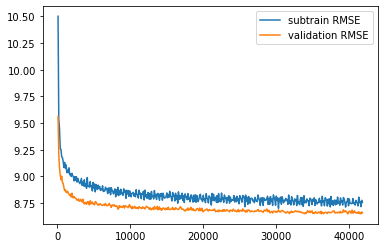

In [52]:
test_RMSE = Q5_model.test(device, H, model, testloader)
print('when H = {}, test_RMSE = {}, with droupout and optimizer = Adam'.format(H, test_RMSE))
Q5_model.plot()

從圖形中可以看書training error和validation error都有降下，但training error比validation高。顯示出模型受到drop out的影響，因為在訓練的過程內設計drop out，只留下一部分的feature來產生output，會導致留下來的feature對output影響結果變強。等到進入validation階段的時候，全部的neuron一起運作就會讓output的結果更好(error更小)

### Q6

In [10]:
# Settings
device = 'cuda' if torch.cuda.is_available() else 'cpu'
nepoch = 100
log_interval = 100
H_list = [20, 45, 180, 360]
lr = 0.001
input_shape = subtrainset.Xnp.shape[1]


for H in H_list:
    Q6_model = myMLP()
    net = Q6_model.Net(input_shape, device, H, dropout = True)
    optimizer = torch.optim.Adam(net.parameters(), lr = lr)
    model = Q6_model.train(device, net, nepoch, log_interval, optimizer, subtrainloader, validloader, verbose = False)
    test_RMSE = Q6_model.test(device, H, model, testloader)
    print('when H = {}, test_RMSE = {}'.format(H, test_RMSE))

when H = 20, test_RMSE = 9.111369019732795
when H = 45, test_RMSE = 8.942904964925495
when H = 180, test_RMSE = 8.845475334009166
when H = 360, test_RMSE = 8.832860358895017


與Q2-Q5的結果不同，在有drop out及使用Adam演算法的結果之下，H越大反而越不會overfitting

### Q7

In [53]:
class myMLP_2():
    def __init__(self):
        self.batch_num = None
        self.subtrainRMSE = list()
        self.validRMSE = list()
        self.mse = torch.nn.MSELoss(reduction = 'mean')
        self.sse = torch.nn.MSELoss(reduction = 'sum')
        self.L1 = torch.nn.L1Loss(reduction = 'sum')
        self.net = None

    def Net(self, input_shape, device, H = 45, dropout = False):
        D_in = input_shape
        H = H
        D_out = 1
        if dropout == False:
              net = torch.nn.Sequential(
                  torch.nn.Linear(D_in, H),  
                  torch.nn.ReLU(),
                  torch.nn.Linear(H, H),
                  torch.nn.ReLU(),
                  torch.nn.Linear(H, H),
                  torch.nn.ReLU(),
                  torch.nn.Linear(H, H),
                  torch.nn.ReLU(),
                  torch.nn.Linear(H, D_out)
              )

        if dropout == True:
            net = torch.nn.Sequential(
            torch.nn.Linear(D_in, H),  
            torch.nn.ReLU(),
            torch.nn.Dropout(p = 0.5),
            torch.nn.Linear(H, H),
            torch.nn.ReLU(),
            torch.nn.Dropout(p = 0.5),
            torch.nn.Linear(H, H),
            torch.nn.ReLU(),
            torch.nn.Dropout(p = 0.5),
            torch.nn.Linear(H, H),
            torch.nn.ReLU(),
            torch.nn.Dropout(p = 0.5),
            torch.nn.Linear(H, D_out)
            )

        # convert everything to float precision. 
        net = net.float()
        # move the model to device (i.e., cpu or gpu)
        net = net.to(device)
        return net

  # Train
    def train(self, device, model, nepoch, log_interval, optimizer, z, train_loader, valid_loader, verbose = True, customized_loss = False):

        # Early stopping
        min_valid_loss = 10000000
        best_step_count = 0
        patience = 5000
    
        sum_loss_MSE = 0
        step_count = 0
        for epoch_idx in range(1, nepoch+1):
          #1 epoch = 400 batch (1 batch = 1000 data points)    
          for batch_idx, (inputs, targets) in enumerate(train_loader):
            #reshape target to two-dimensional array
            targets = targets.reshape((-1, 1))
            step_count += 1        
            model.train()
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            #loss for update        
            loss_SSE = self.sse(outputs, targets)
            loss_L1 = self.L1(outputs, targets)
            if customized_loss == True:
                total_loss = z * loss_SSE + (1-z) * 0.5 * loss_L1
            else:
                total_loss = z * loss_SSE + (1-z) * loss_L1
            #loss for show
            loss_MSE = self.mse(outputs, targets)
            total_loss.backward()
            optimizer.step()
            sum_loss_MSE += loss_MSE
            if step_count % log_interval == 0:
            #1000 = batch_size, 100 = number of batch         
                RMSE_train = (sum_loss_MSE / log_interval) ** (1/2)
                RMSE_valid = self.validation(model, device, log_interval, valid_loader)
                self.subtrainRMSE.append(RMSE_train)
                self.validRMSE.append(RMSE_valid)
                if verbose == True:
                    print("Epoch %d Step %d training loss = %.3f validation loss = %3f (minibatch size = %d)" % (epoch_idx, step_count, RMSE_train, RMSE_valid, len(targets))) 

                if RMSE_valid < min_valid_loss:
                    best_step_count = step_count
                    min_valid_loss = RMSE_valid
                    best_model = model
                sum_loss_MSE = 0 

            if step_count >= best_step_count + patience and RMSE_valid > min_valid_loss:
                if verbose == True:
                    print('Early stopping!')
                    print('='*50 + 'validation result' + '='*50)
                    print('the best step is {} with minimum validation error = {}'.format(best_step_count, min_valid_loss))
                    self.batch_num = step_count
                return best_model
        if verbose == True:
            print('='*50 + 'result' + '='*50)
            print('the best step is {} with minimum validation error = {}'.format(best_step_count, min_valid_loss))
        self.batch_num = step_count
        return best_model


    def validation(self, model, device, log_interval, valid_loader):
        #切到evaluate的模式，不會進行gradient descent
        model.eval()
        total_loss = 0
        with torch.no_grad():
            #1 epoch = 40 batch
            for batch_idx, (inputs, targets) in enumerate(valid_loader):            
                inputs, targets = inputs.to(device), targets.to(device)
                targets = targets.reshape((-1, 1))
                outputs = model(inputs)        
                valid_loss = self.mse(outputs, targets)
                #print(batch_idx, valid_loss)
                total_loss += valid_loss
        RMSE = (total_loss / batch_idx) ** (1/2)
        #print(batch_idx)
        return RMSE

    def test(self, device, H, net, test_loader):
        net.eval()
        sum_test_MSE = 0
        with torch.no_grad():
            for batch_idx, (inputs, targets) in enumerate(test_loader):            
            inputs, targets = inputs.to(device), targets.to(device)
            targets = targets.reshape((-1, 1))
            outputs = net(inputs)        
            test_loss = self.mse(outputs, targets).item()
            sum_test_MSE += test_loss 
        test_RMSE = (sum_test_MSE / batch_idx) ** (1/2)
        return test_RMSE
  
    def plot(self):
        #print subtraining result
        fig = plt.figure()
        ax = plt.axes()
        x = np.linspace(100, self.batch_num, self.batch_num // 100)
        ax.plot(x, self.subtrainRMSE, label = 'subtrain RMSE')
        ax.plot(x, self.validRMSE, label = 'validation RMSE')
        ax.legend()
        #plt.title('H = {}')
        plt.show()

In [54]:
# Settings
device = 'cuda' if torch.cuda.is_available() else 'cpu'
nepoch = 100
log_interval = 100
H = 90
z = 0.5
lr = 0.001
input_shape = subtrainset.Xnp.shape[1]

Q7_model = myMLP_2()
net = Q7_model.Net(input_shape, device, H, dropout = True)
optimizer = torch.optim.Adam(net.parameters(), lr = lr)
model = Q7_model.train(device, net, nepoch, log_interval, optimizer, z, subtrainloader, validloader, verbose = True, customized_loss = False)

Epoch 1 Step 100 training loss = 10.541 validation loss = 9.562422 (minibatch size = 1000)
Epoch 1 Step 200 training loss = 9.553 validation loss = 9.196228 (minibatch size = 1000)
Epoch 1 Step 300 training loss = 9.429 validation loss = 9.061416 (minibatch size = 1000)
Epoch 1 Step 400 training loss = 9.254 validation loss = 9.011939 (minibatch size = 1000)
Epoch 2 Step 500 training loss = 9.250 validation loss = 8.945481 (minibatch size = 1000)
Epoch 2 Step 600 training loss = 9.141 validation loss = 8.948561 (minibatch size = 1000)
Epoch 2 Step 700 training loss = 9.162 validation loss = 8.919297 (minibatch size = 1000)
Epoch 2 Step 800 training loss = 9.118 validation loss = 8.906487 (minibatch size = 1000)
Epoch 3 Step 900 training loss = 9.069 validation loss = 8.882791 (minibatch size = 1000)
Epoch 3 Step 1000 training loss = 9.100 validation loss = 8.854530 (minibatch size = 1000)
Epoch 3 Step 1100 training loss = 9.036 validation loss = 8.850271 (minibatch size = 1000)
Epoch 3

when H = 90, z = 0.5, optimizer = Adam, with dropout layers and loss function = L1 + L2,test_RMSE = 8.868124172787063


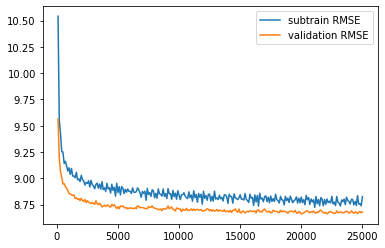

In [55]:
test_RMSE = Q7_model.test(device, H, model, testloader)
print('when H = {}, z = {}, optimizer = Adam, with dropout layers and loss function = L1 + L2,test_RMSE = {}'.format(H, z, test_RMSE))
Q7_model.plot()

In [56]:
# GPU device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Settings
nepoch = 100
log_interval = 100
lr = 0.001
H = 90
z_list = [0.0, 0.1, 0.5, 0.9, 1.0]
input_shape = subtrainset.Xnp.shape[1]

for z in z_list:
    Q7_model = myMLP_2()
    net = Q7_model.Net(input_shape, device, H, dropout = True)
    optimizer = torch.optim.Adam(net.parameters(), lr = lr)
    model = Q7_model.train(device, net, nepoch, log_interval, optimizer, z, subtrainloader, validloader, verbose = False, customized_loss = False)
    test_RMSE = Q7_model.test(device, H, model, testloader)
    print('when z = {}, test RMSE = {}'.format(z, test_RMSE))

when z = 0.0, test RMSE = 9.093717888731122
when z = 0.1, test RMSE = 8.856340076544237
when z = 0.5, test RMSE = 8.875307871596679
when z = 0.9, test RMSE = 8.866222049150258
when z = 1.0, test RMSE = 8.87368043172306


從結果可以發現，完全只依賴L2 loss(z=1)或完全只依賴L1 loss(z=0)來更新參數對模型並不是最好的選擇；經過調整參數後可以觀察到z=0.1時模型的結果會最好。

### Q8

In [57]:
# Settings
device = 'cuda' if torch.cuda.is_available() else 'cpu'
nepoch = 100
log_interval = 100
H = 90
z = 0
lr = 0.001
input_shape = subtrainset.Xnp.shape[1]

Q8_model = myMLP_2()
net = Q8_model.Net(input_shape, device, H, dropout = True)
optimizer = torch.optim.Adam(net.parameters(), lr = lr)
model = Q8_model.train(device, net, nepoch, log_interval, optimizer, z, subtrainloader, validloader, verbose = True, customized_loss = True)

Epoch 1 Step 100 training loss = 10.991 validation loss = 10.685866 (minibatch size = 1000)
Epoch 1 Step 200 training loss = 10.523 validation loss = 10.159313 (minibatch size = 1000)
Epoch 1 Step 300 training loss = 9.961 validation loss = 9.471992 (minibatch size = 1000)
Epoch 1 Step 400 training loss = 9.626 validation loss = 9.387156 (minibatch size = 1000)
Epoch 2 Step 500 training loss = 9.627 validation loss = 9.296260 (minibatch size = 1000)
Epoch 2 Step 600 training loss = 9.503 validation loss = 9.263186 (minibatch size = 1000)
Epoch 2 Step 700 training loss = 9.528 validation loss = 9.255858 (minibatch size = 1000)
Epoch 2 Step 800 training loss = 9.484 validation loss = 9.286282 (minibatch size = 1000)
Epoch 3 Step 900 training loss = 9.429 validation loss = 9.203110 (minibatch size = 1000)
Epoch 3 Step 1000 training loss = 9.460 validation loss = 9.200662 (minibatch size = 1000)
Epoch 3 Step 1100 training loss = 9.385 validation loss = 9.139770 (minibatch size = 1000)
Epoc

when H = 90, z = 0, optimizer = Adam, with dropout layers and loss function = qloss, test_RMSE = 9.059434352881812


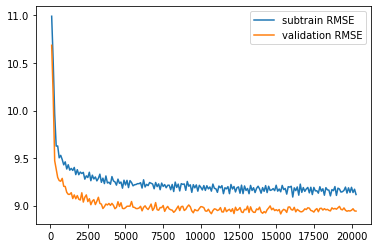

In [58]:
test_RMSE = Q8_model.test(device, H, model, testloader)
print('when H = {}, z = {}, optimizer = Adam, with dropout layers and loss function = qloss, test_RMSE = {}'.format(H, z, test_RMSE))
Q8_model.plot()

In [59]:
# GPU device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Settings
nepoch = 100
H = 90
log_interval = 100
lr = 0.001
input_shape = subtrainset.Xnp.shape[1]

z_list = [0.0, 0.1, 0.5, 0.9, 1.0]

for z in z_list:
    Q8_model = myMLP_2()
    net = Q8_model.Net(input_shape, device, H, dropout = True)
    optimizer = torch.optim.Adam(net.parameters(), lr = lr)
    model = Q8_model.train(device, net, nepoch, log_interval, optimizer, z, subtrainloader, validloader, verbose = False, customized_loss = True)
    test_RMSE = Q8_model.test(device, H, model, testloader)
    print('when z = {}, test RMSE = {}'.format(z, test_RMSE))

when z = 0.0, test RMSE = 9.08860612044098
when z = 0.1, test RMSE = 8.87004020718403
when z = 0.5, test RMSE = 8.85698223468173
when z = 0.9, test RMSE = 8.860057186242193
when z = 1.0, test RMSE = 8.877733771913698


與前一提的結果類似，完全只依賴L2 loss(z=1)或完全只依賴qloss(z=0)來更新參數對模型並不是最好的選擇；經過調整參數後可以觀察到z=0.5，也就是各使用一半的loss來更新模型時結果會最好。